# 📬 Spam Classification with TF-IDF and Neural Networks

This project presents a binary text classification model designed to distinguish between spam and ham (non-spam) SMS messages. It uses a combination of natural language processing (NLP) techniques and a fully connected neural network built with Keras.

### 🔍 Key Features
📊 Dataset: Public SMS spam collection (spam.csv)

### 🧹 Preprocessing:

* Stopwords removal using NLTK

* TF-IDF vectorization to transform text into feature vectors

### 🧠 Model Architecture:

* Dense Neural Network with configurable regularization (L1, L2, Dropout, BatchNorm)

* Binary classification using sigmoid activation

#### 📈 Metrics Visualization:

* Plots training and validation accuracy/loss over epochs

#### 🧪 Objective

* To evaluate how different regularization techniques affect the model’s ability to generalize and avoid overfitting on a simple NLP classification task.

## Objectives


*   Understand how the regularization techniques (L1, L2, Dropout, BatchNorm) work for neural networks.
*   Describe the difference between L1 and L2 regularization.
*   Apply the four types of regularization when training neural networks.

In [2]:
%%capture
%pip install nltk

### Importing Required Libraries

We recommend you import all required libraries in one place, as follows:

In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


### Defining Helper Functions






This function helps prepare the SMS Spam dataset.

In [4]:
def prepare_data():
    try:
        data = pd.read_csv("spam.csv", encoding='latin-1')
    except FileNotFoundError:
        print("Data file not found, make sure it's downloaded.")
        
    data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1, inplace=True)
    data.rename(columns={"v1": "label", "v2": "text"}, inplace=True)
    data.label = data['label'].map({'ham':0, 'spam':1})
    data['Count'] = data['text'].apply(lambda x: len(x))
    
    sw=stopwords.words("english")
    vectorizer = TfidfVectorizer(stop_words=sw, binary=True)

    X = vectorizer.fit_transform(data.text).toarray()
    y = data.label
    
    return X, y

In [5]:
#This function plots the loss and accuracy curve from the training history of a neural network.
def plot_metrics(history):
    fig = plt.figure(figsize=(10,5))
    for i, metric in enumerate(['accuracy', 'loss']):
        train_metrics = history.history[metric]
        val_metrics = history.history['val_'+metric]
        epochs = range(1, len(train_metrics) + 1)
        plt.subplot(1,2,i+1)
        plt.plot(epochs, train_metrics)
        plt.plot(epochs, val_metrics)
        plt.title('Training and validation '+ metric)
        plt.xlabel("Epochs")
        plt.ylabel(metric)
        plt.legend(["train_"+metric, 'val_'+metric])


### Using L2 Regularization in Keras

In Keras, regularization penalties are applied on a per-layer basis, that is, you specify the name of the regularizer API as you add a layer to the network. The `tf.keras.regularizers` module has a built-in L2 class that you can call using the following:


In [8]:
tf.keras.regularizers.l2(l2=0.01)

This object can be passed as an argument to a Dense layer:

In [9]:
dense_layer = Dense(32, 
                activation="relu", 
                kernel_regularizer=tf.keras.regularizers.l2(l2=0.01))

### Using L1 Regularization in Keras

Similar to how we used L2, `tf.keras.regularizers` module also has a built-in L1 class:

In [11]:
dense_layer = Dense(32, 
            activation="relu", 
            kernel_regularizer=tf.keras.regularizers.l1(l1=0.01))

In [12]:
dense_layer = Dense(32, 
                activation="relu", 
                kernel_regularizer="l1")

### Using Dropout in Keras

In Keras, Dropout can be applied using the Dropout class from **keras.layers**. A dropout rate can be specified when creating the dropout layer, which is the percentage of neurons that will be turned off during one update.

In [13]:
from tensorflow.keras.layers import Dropout

dropout_layer = Dropout(rate=0.2)

### Using Batch Normalization in Keras

In Keras, you can add a Batch Norm layer between the Dense layers by calling `BatchNormalization()` from **keras.layers**. Here is a code example:

In [14]:
from tensorflow.keras.layers import Dense, BatchNormalization

batchnorm_layer = BatchNormalization()

##  Spam Classification

In this example, we will dive into a real world application, which is a spam classification problem. We will work with the [SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset) from Kaggle and use neural networks for classifying a message as either Spam or Ham (not spam).

We first download and display the raw dataset:

In [18]:
import skillsnetwork

await skillsnetwork.download("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module1/L3/data/spam.csv")

Saved as 'spam.csv'


In [19]:
data = pd.read_csv("spam.csv", encoding="latin-1")
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


By calling the helper function **prepare_data**, we obtain a matrix $\boldsymbol X$ which contains the pre-processed text data (mainly using the **TfidfVectorizer** from scikit-learn's **feature_extraction** module) and an object $\boldsymbol y$ which contains the labels of the messages. 

There are 5572 text messages that will be classified as either spam **(1)** or non-spam **(0)**, and they are 8536-dimensional data.


In [20]:
X, y = prepare_data()
X.shape, y.shape

((5572, 8536), (5572,))

### Model Configuration and Training

The **get_model** function provides the layer configuration ane the training of a neural network for different specifications of the regularization technique used. For example, by setting `reg='L1'`, the network's Dense layers will be regularized by L1, and then at the end of the training, the loss and accuracy curve of the train and validation set will be plotted.


In [35]:
input_dim = X.shape[1]
   
def get_model(reg=None, epochs=10):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(input_dim,)))
    if reg=="L1":
        model.add(Dense(256, activation='relu', kernel_regularizer="l1"))
        model.add(Dense(64, activation='relu', kernel_regularizer="l1"))
    elif reg=="L2":
        model.add(Dense(256, activation='relu', kernel_regularizer="l2"))
        model.add(Dense(64, activation='relu', kernel_regularizer="l2"))
    elif reg=="Dropout":
        model.add(Dropout(0.2))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
    elif reg=="BatchNorm":
        model.add(BatchNormalization())
        model.add(Dense(256, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())  
    else:
        model.add(Dense(256, activation='relu'))
        model.add(Dense(64, activation='relu'))  
 
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy", optimizer="adam",
                 metrics=["accuracy"])
    history = model.fit(X, y, batch_size=64, validation_split=0.2,
              epochs=epochs)
    plot_metrics(history)
    return history


### Baseline: No Regularization

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8133 - loss: 0.4260 - val_accuracy: 0.9740 - val_loss: 0.1234
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9931 - loss: 0.0618 - val_accuracy: 0.9812 - val_loss: 0.0648
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9803 - val_loss: 0.0765
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 1.0000 - loss: 4.7053e-04 - val_accuracy: 0.9794 - val_loss: 0.0943
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.0000 - loss: 1.5749e-04 - val_accuracy: 0.9794 - val_loss: 0.1024
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.0000 - loss: 7.8318e-05 - val_accuracy: 0.9794 - val_loss: 0.1077
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 7.3676e-05 - val_accuracy: 0.9794 - val_loss: 0.1128
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 1.0000 - loss: 4.3834e-05 - val_

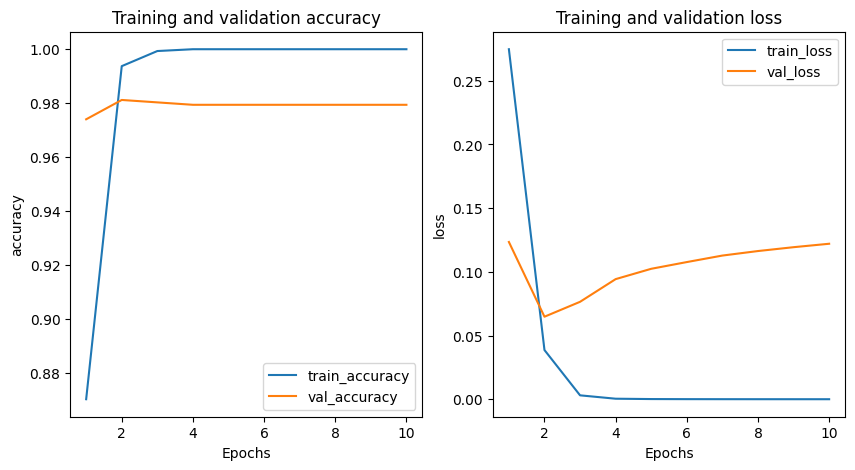

In [36]:
get_model()

You can see that without regularization, our training set accuracy is generally higher than validation accuracy, which means the model is overfitted to the training set.

### L1 Regularization

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8356 - loss: 48.4009 - val_accuracy: 0.8700 - val_loss: 6.4131
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8678 - loss: 3.4716 - val_accuracy: 0.8700 - val_loss: 0.6580
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8634 - loss: 0.6175 - val_accuracy: 0.8700 - val_loss: 0.5660
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.8726 - loss: 0.5604 - val_accuracy: 0.8700 - val_loss: 0.5637
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8602 - loss: 0.5819 - val_accuracy: 0.8700 - val_loss: 0.5635
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8592 - loss: 0.5837 - val_accuracy: 0.8700 - val_loss: 0.5636
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8693 - loss: 0.5648 - val_accuracy: 0.8700 - val_loss: 0.5630
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8659 - loss: 0.5710 - val_accuracy: 0.8700 - 

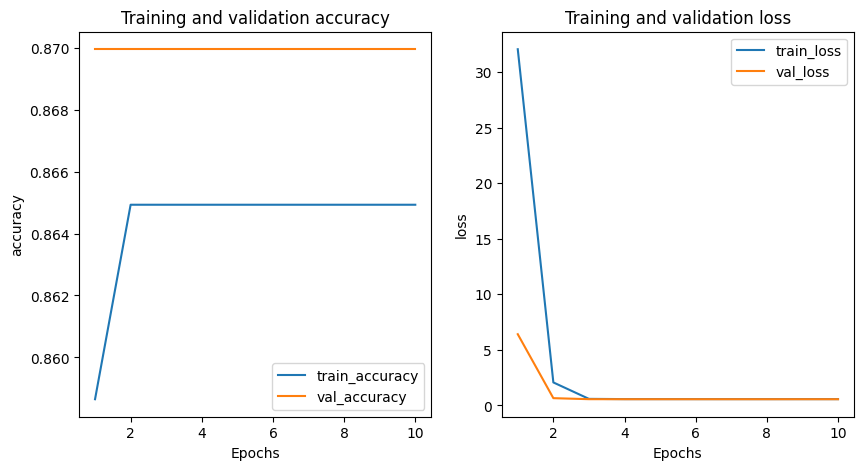

In [37]:
get_model(reg="L1")

With L1 regularization, we can see that the validation accuracy is now higher than the training accuracy, meaning the L1 regularization mitigated the overfitting issue. However, if we look closer at the y-axis, we can see that in fact the accuracy value in general (both train and validation) is lower than the baseline model. 

For the baseline model, the validation accuracy was always above 0.97 even though it's slightly lower than the training accuracy. This indicates that, by using the default L1 regularization with shrinkage strength equals 0.001, our model is underfitting.

### L2 Regularization

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8554 - loss: 3.2687 - val_accuracy: 0.9605 - val_loss: 0.5440
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.9805 - loss: 0.3717 - val_accuracy: 0.9785 - val_loss: 0.1632
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9971 - loss: 0.1036 - val_accuracy: 0.9794 - val_loss: 0.1167
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9993 - loss: 0.0653 - val_accuracy: 0.9776 - val_loss: 0.1065
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9994 - loss: 0.0519 - val_accuracy: 0.9776 - val_loss: 0.0992
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9999 - loss: 0.0428 - val_accuracy: 0.9776 - val_loss: 0.0953
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9998 - loss: 0.0362 - val_accuracy: 0.9776 - val_loss: 0.0912
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9994 - loss: 0.0330 - val_accuracy: 0.9776 - v

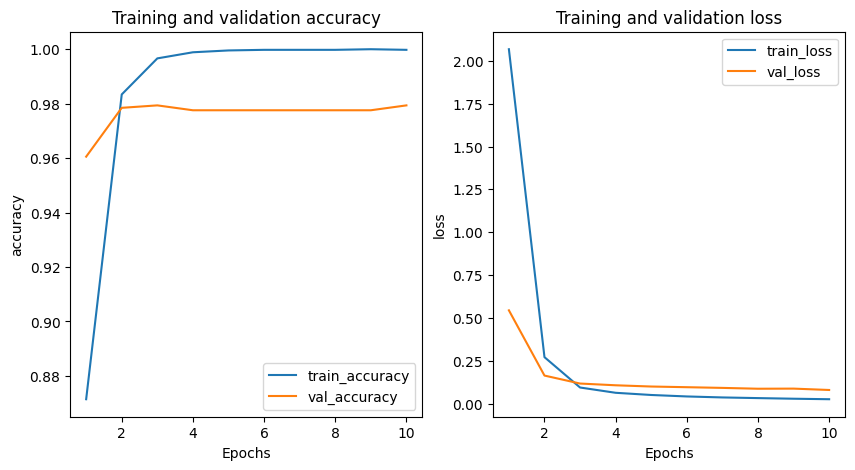

In [38]:
get_model(reg="L2")

With L2 regularization, the gap between training accuracy and validation accuracy narrowed a little bit. The training accuracy was not always 1.0 compared to the baseline and the validation accuracy had more fluctuations than the baseline.

### Dropout

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8644 - loss: 0.4022 - val_accuracy: 0.9686 - val_loss: 0.1349
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.9829 - loss: 0.0917 - val_accuracy: 0.9785 - val_loss: 0.0791
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.9803 - val_loss: 0.0812
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 1.0000 - loss: 3.7737e-04 - val_accuracy: 0.9794 - val_loss: 0.0965
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 1.9192e-04 - val_accuracy: 0.9785 - val_loss: 0.1065
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 1.0804e-04 - val_accuracy: 0.9785 - val_loss: 0.1097
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 6.9453e-05 - val_accuracy: 0.9794 - val_loss: 0.1151
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 4.1624e-05 - val_

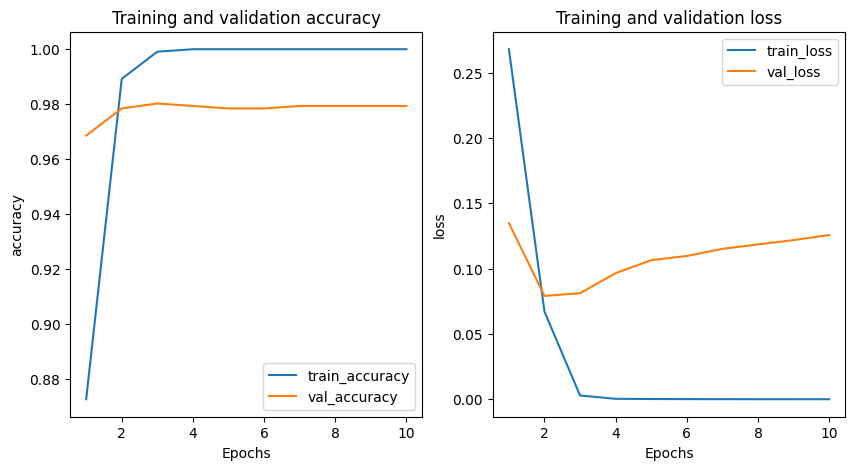

In [39]:
get_model(reg="Dropout")

With dropout, the resulting curves are very similar to the baseline, so perhaps dropout is not very effective in our case.

### Batch Normalization

Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.8578 - loss: 0.4062 - val_accuracy: 0.9767 - val_loss: 0.1308
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9927 - loss: 0.0778 - val_accuracy: 0.9785 - val_loss: 0.0800
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9991 - loss: 0.0050 - val_accuracy: 0.9794 - val_loss: 0.0896
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.0000 - loss: 4.6021e-04 - val_accuracy: 0.9776 - val_loss: 0.1062
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 1.8993e-04 - val_accuracy: 0.9776 - val_loss: 0.1100
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 1.0000 - loss: 1.0495e-04 - val_accuracy: 0.9776 - val_loss: 0.1143
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 5.6175e-05 - val_accuracy: 0.9794 - val_loss: 0.1175
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 1.0000 - loss: 3.2664e-05 - val_

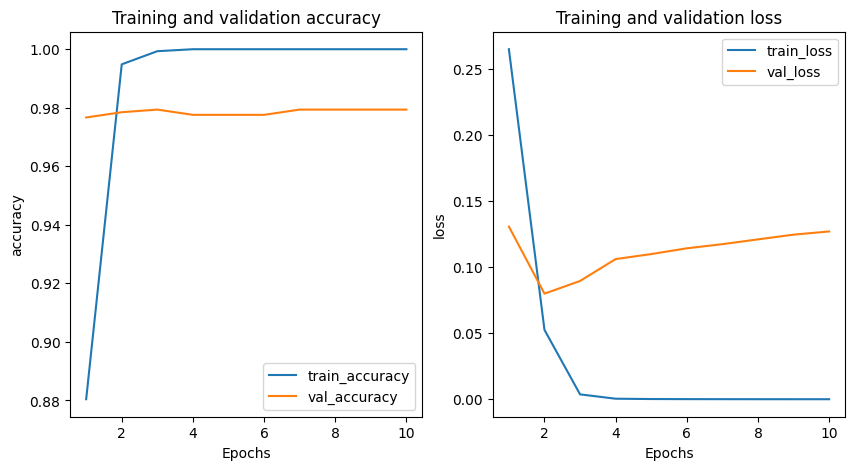

In [40]:
get_model(reg="BathNorm")

With Batch Norm, the final training accuracy is 1.0 and final validation accuracy is 0.9812, which is slightly higher than before (0.9794). We can conclude that Batch Normalization is a relatively better choice for regularizing neural network training.

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def compare_models(histories):
    final_accuracies = {}

    for label, history in histories.items():
        val_acc = history.history['val_accuracy']
        final_accuracies[label] = val_acc[-1]

    models = list(final_accuracies.keys())
    accuracies = list(final_accuracies.values())

    colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, accuracies, color=colors, alpha=0.85)

    
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height - 0.03, f"{acc:.2f}",
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    plt.title("Final Validation Accuracy by Regularization Type", fontsize=14)
    plt.xlabel("Regularization Method", fontsize=12)
    plt.ylabel("Validation Accuracy", fontsize=12)
    plt.ylim(0, 1.05)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()





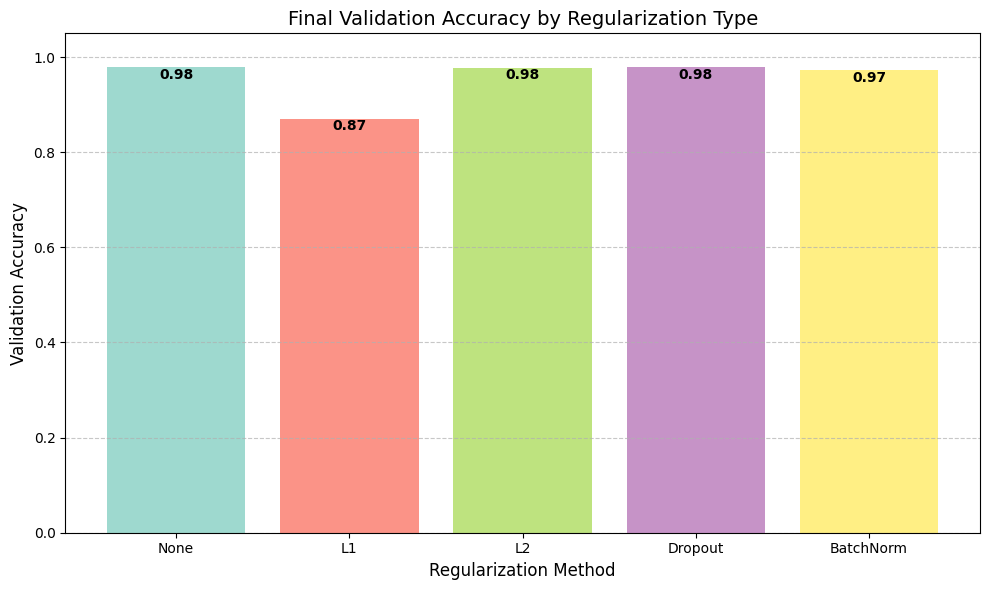

In [55]:
compare_models(histories)
